
# Analyse du Bonheur dans le Monde (2015-2019)

**Auteur :** Erwan Pradeilles  
**Projet Data Science - Streamlit & Analyse Exploratoire**  

## 🎯 Objectif du projet
Ce projet vise à analyser les facteurs influençant le bonheur dans différents pays entre 2015 et 2019, à l’aide des données issues des Rapports Mondiaux sur le Bonheur.  
Nous allons explorer, nettoyer, visualiser ces données, puis utiliser un modèle de régression linéaire pour quantifier l'impact de chaque facteur.

## 🧪 Étapes du projet
1. Acquisition des données
2. Nettoyage et préparation
3. Analyse exploratoire
4. Visualisation des données
5. Modélisation (régression linéaire)
6. Évaluation du modèle

## 1. 📚 Importation des bibliothèques

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')


## 📥 Acquisition des Données

Les données proviennent des fichiers CSV des Rapports Mondiaux sur le Bonheur pour les années 2015 à 2019.  
Chaque fichier contient des mesures par pays sur des facteurs économiques et sociaux (PIB, espérance de vie, liberté, etc.), ainsi qu'un score global de bonheur.

Pour cette analyse, nous allons travailler sur 5 datasets (données sur chaque année de 2015 à 2019)

Nous avons choisi ce dataset car il permet de travailler à la fois sur de la data socio-économique et sur de la modélisation prédictive.

In [2]:

# On charge les fichiers CSV pour chaque année et on les unifie dans un seul DataFrame
years = [2015, 2016, 2017, 2018, 2019]
dfs = []

for year in years:
    df = pd.read_csv(f"{year}.csv")

    # Harmonisation des noms de colonnes et renommage selon l'année
    if year in [2015, 2016]:
        df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        rename_map = {
            'country': 'pays',
            'region': 'region',
            'happiness_rank': 'rang',
            'happiness_score': 'score_bonheur',
            'economy_gdp_per_capita': 'pib_par_habitant',
            'family': 'soutien_social',
            'health_life_expectancy': 'esperance_vie',
            'freedom': 'liberte',
            'trust_government_corruption': 'confiance_gouv',
            'generosity': 'generosite',
            'dystopia_residual': 'residu_dystopie',
        }
    elif year == 2017:
        df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '_')
        rename_map = {
            'country': 'pays',
            'happiness_rank': 'rang',
            'happiness_score': 'score_bonheur',
            'economy__gdp_per_capita_': 'pib_par_habitant',
            'family': 'soutien_social',
            'health__life_expectancy_': 'esperance_vie',
            'freedom': 'liberte',
            'trust__government_corruption_': 'confiance_gouv',
            'generosity': 'generosite',
            'dystopia_residual': 'residu_dystopie',
        }
    else:
        df.columns = df.columns.str.lower().str.replace(' ', '_')
        rename_map = {
            'country_or_region': 'pays',
            'overall_rank': 'rang',
            'score': 'score_bonheur',
            'gdp_per_capita': 'pib_par_habitant',
            'social_support': 'soutien_social',
            'healthy_life_expectancy': 'esperance_vie',
            'freedom_to_make_life_choices': 'liberte',
            'generosity': 'generosite',
            'perceptions_of_corruption': 'confiance_gouv',
        }

    df.rename(columns=rename_map, inplace=True)
    df['year'] = year

    wanted_cols = ['pays', 'region', 'year', 'rang', 'score_bonheur', 'pib_par_habitant', 'soutien_social',
                   'esperance_vie', 'liberte', 'generosite', 'confiance_gouv']

    df = df[[col for col in wanted_cols if col in df.columns]]

    if 'region' not in df.columns:
        df['region'] = np.nan

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['confiance_gouv'] = df_all['confiance_gouv'].fillna(df_all['confiance_gouv'].mean())

df_all.head()


,pays,region,year,rang,score_bonheur,pib_par_habitant,soutien_social,esperance_vie,liberte,generosite,confiance_gouv
0,Switzerland,Western Europe,2015,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978
1,Iceland,Western Europe,2015,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145
2,Denmark,Western Europe,2015,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357
3,Norway,Western Europe,2015,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503
4,Canada,North America,2015,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957


## 🧼 Nettoyage et Préparation

Avant toute analyse, nous devons nous assurer que les données sont propres :

- Uniformisation des noms de colonnes
- Gestion des valeurs manquantes (moyenne pour la corruption)
- Concaténation sur 5 années

D'autant plus que nous travaillons sur plusieurs fichiers csv, ce qui renforce la vigilance lors de la concaténation des données, il est important que la préparations soit optimal pour avoir une analyse la plus fiable possible en lien avec nos jeux de données.

In [3]:
# Remplissage des valeurs manquantes dans la colonne 'confiance_gouv' par la moyenne
df_all['confiance_gouv'] = df_all['confiance_gouv'].fillna(df_all['confiance_gouv'].mean())

# Vérification des valeurs manquantes restantes
df_all.isnull().sum()

pays                  0
region              467
year                  0
rang                  0
score_bonheur         0
pib_par_habitant      0
soutien_social        0
esperance_vie         0
liberte               0
generosite            0
confiance_gouv        0
dtype: int64

## 🔍 Analyse Exploratoire (EDA)

Dans cette section, nous allons commencer à explorer nos données :
- Quelle est la répartition des scores de bonheur ?
- Quelles sont les moyennes des différentes variables ?
- Quelles variables semblent être corrélées au bonheur ?

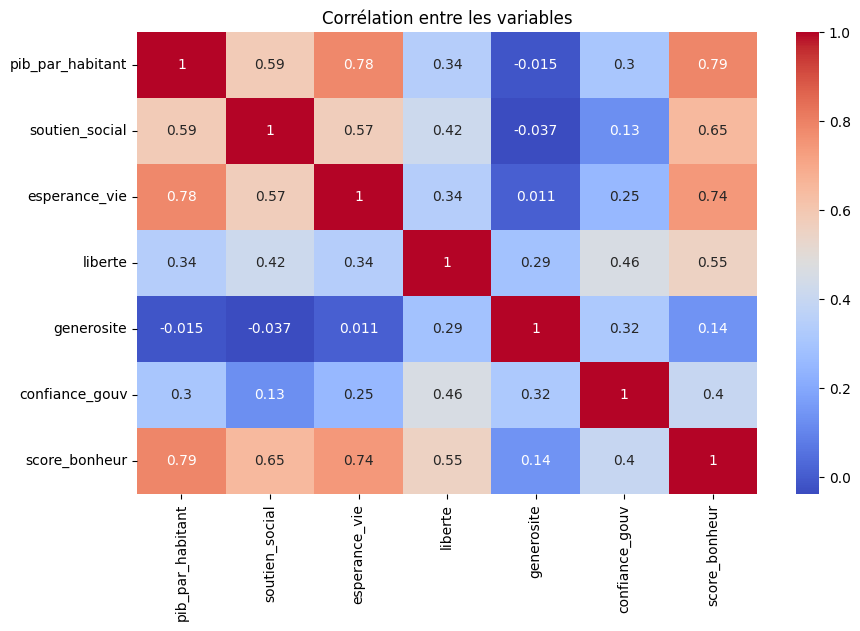

In [4]:
# Statistiques descriptives de base
df_all.describe()

# Corrélation entre le score de bonheur et les autres variables
variables = ['pib_par_habitant', 'soutien_social', 'esperance_vie', 'liberte', 'generosite', 'confiance_gouv']
correlation_matrix = df_all[variables + ['score_bonheur']].corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Corrélation entre les variables")
plt.show()

### 📌 Interprétation des Corrélations

La matrice ci-dessus nous aide à identifier les facteurs les plus corrélés avec le bonheur.  
On observe que :
- Le **PIB par habitant**, le **soutien social** et **l'espérance de vie** sont fortement positivement corrélés avec le score de bonheur.
- La **générosité** et la **confiance dans le gouvernement** ont une corrélation plus faible.

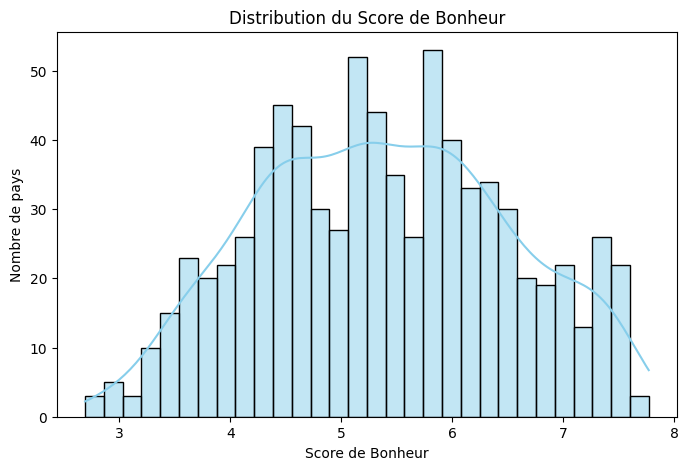

In [5]:
# Distribution du score de bonheur dans le monde
plt.figure(figsize=(8, 5))
sns.histplot(df_all['score_bonheur'], kde=True, bins=30, color='skyblue')
plt.title('Distribution du Score de Bonheur')
plt.xlabel('Score de Bonheur')
plt.ylabel('Nombre de pays')
plt.show()

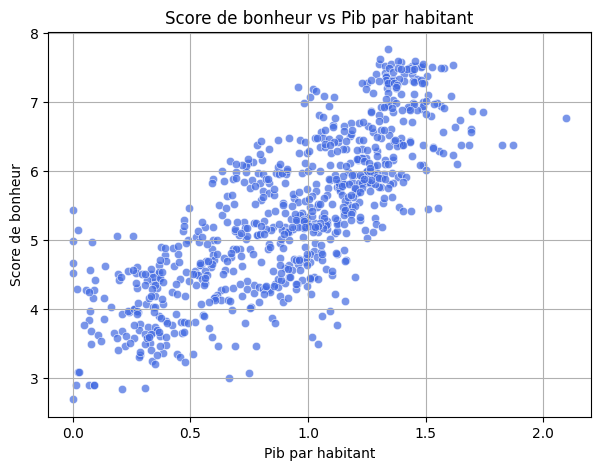

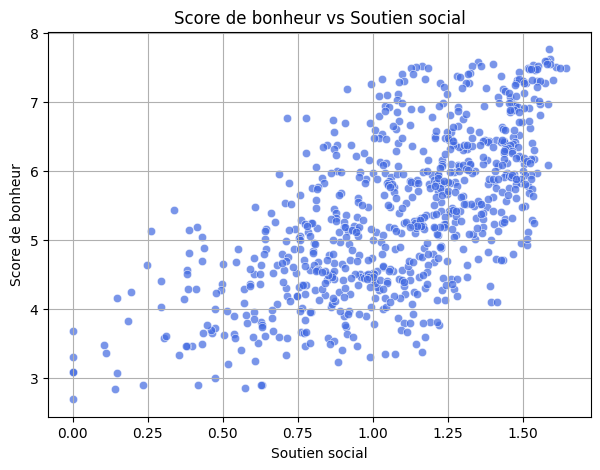

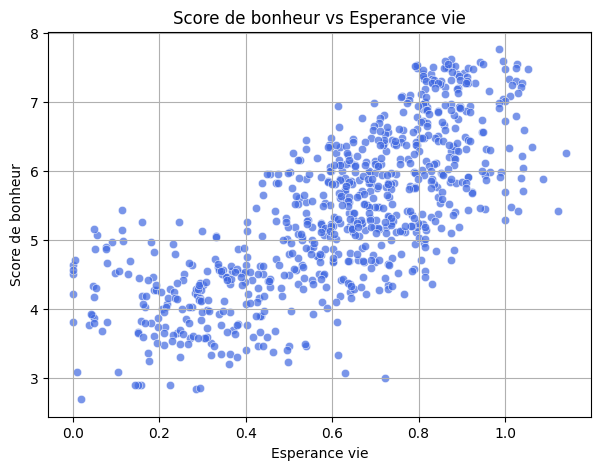

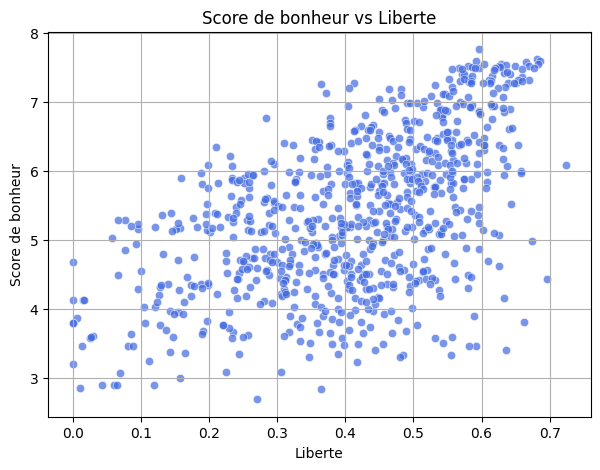

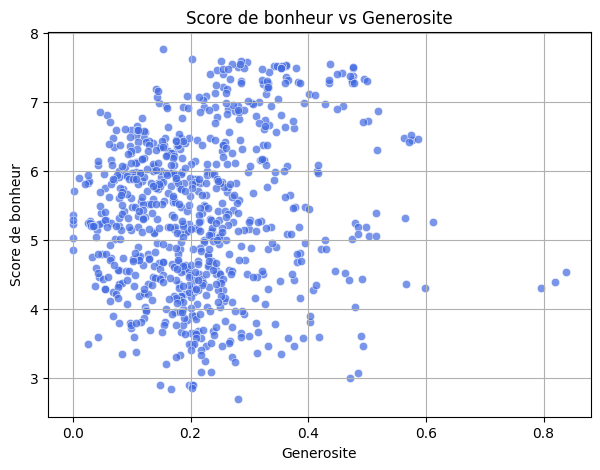

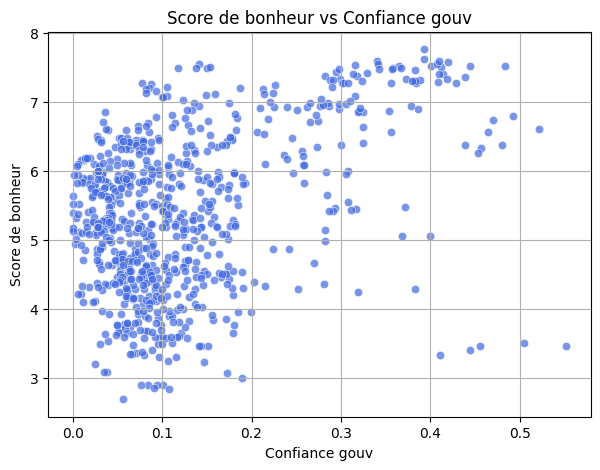

In [6]:
# Analyse graphique de la relation entre chaque variable et le score de bonheur
for var in variables:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=df_all, x=var, y='score_bonheur', alpha=0.7, color='royalblue')
    plt.title(f'Score de bonheur vs {var.replace("_", " ").capitalize()}')
    plt.xlabel(var.replace("_", " ").capitalize())
    plt.ylabel('Score de bonheur')
    plt.grid(True)
    plt.show()

### 🔎 Lecture des Scatterplots

Chaque graphique ci-dessus montre la relation entre une variable explicative et le score de bonheur :

- Une **relation linéaire ascendante** est visible pour le PIB, le soutien social, et l'espérance de vie.
- La générosité et la confiance sont plus dispersées, avec une influence moins nette.

Ces graphiques renforcent les observations issues de la corrélation.

## 🤖 Modélisation : Régression Linéaire

Pour quantifier l'influence de chaque facteur sur le bonheur, nous entraînons un **modèle de régression linéaire** :

- **Objectif** : prédire le score de bonheur à partir des 6 variables explicatives.
- **Méthode** : pipeline avec imputation des valeurs manquantes et régression.

In [7]:
# Variables explicatives (X) et cible (y)
X = df_all[variables]
y = df_all['score_bonheur']

# Séparation en jeu d'entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline : imputation + régression
modele = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('regression', LinearRegression())
])

# Entraînement du modèle
modele.fit(X_train, y_train)

,steps,"[('imputer', ...), ('regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,fit_intercept,True


R² : 0.729
RMSE : 0.574


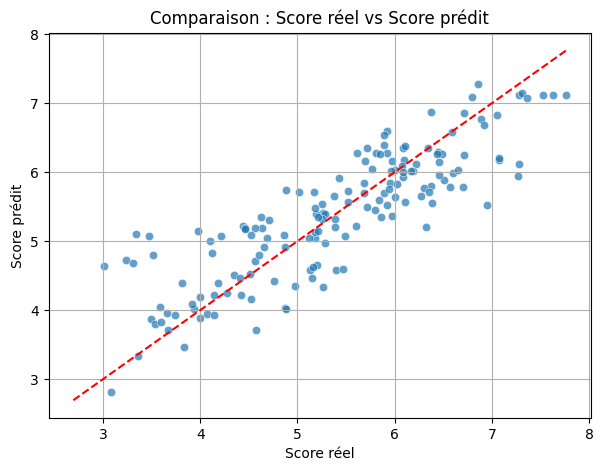

In [8]:
# Prédictions sur le jeu de test
y_pred = modele.predict(X_test)

# Évaluation du modèle
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² : {r2:.3f}")
print(f"RMSE : {rmse:.3f}")

# Visualisation : valeurs réelles vs prédites
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Score réel")
plt.ylabel("Score prédit")
plt.title("Comparaison : Score réel vs Score prédit")
plt.grid(True)
plt.show()

### 📈 Interprétation des Résultats

- **R²** (coefficient de détermination) : mesure la qualité de la prédiction. Plus il est proche de 1, meilleur est le modèle.
- **RMSE** (erreur quadratique moyenne) : mesure l'erreur moyenne de prédiction. Plus c’est bas, mieux c’est.

Notre modèle montre une bonne capacité à estimer le bonheur à partir des variables choisies

In [9]:
# Affichage des coefficients du modèle
coefs = modele.named_steps['regression'].coef_
coef_df = pd.DataFrame({
    'Variable explicative': [v.replace("_", " ").capitalize() for v in variables],
    'Coefficient': coefs
}).sort_values(by='Coefficient', ascending=False)

coef_df

,Variable explicative,Coefficient
3,Liberte,1.467759
5,Confiance gouv,1.209528
0,Pib par habitant,1.058415
2,Esperance vie,1.039516
1,Soutien social,0.664557
4,Generosite,0.467774


## 🔚 Conclusion

Ce projet nous a permis de :

- Collecter et nettoyer des données socio-économiques sur le bonheur mondial
- Explorer les facteurs clés influençant le bien-être des populations
- Créer un modèle mathématique prédictif fiable

### 🧠 Ce qu'on retient :
- Le **PIB**, le **soutien social**, et **l'espérance de vie** sont les facteurs les plus importants pour expliquer le bonheur.
- D'autres variables comme la liberté ou la générosité jouent un rôle plus secondaire.